In [1]:
import gc
import logging
import os
import random
import warnings
from abc import ABCMeta, abstractmethod
from copy import deepcopy
from glob import glob

import easydict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from numpy.typing import NDArray
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from tqdm.auto import tqdm
from typing import Any, Dict, List, Optional, Tuple, Union

warnings.filterwarnings("ignore") 

In [2]:
df = pd.read_csv("./dts/train.csv")
test = pd.read_csv("./dts/test.csv")
submission = pd.read_csv("./dts/sample_submission.csv")

In [3]:
df.head()

,ID,Exercise_Duration,Body_Temperature(F),BPM,Height(Feet),Height(Remainder_Inches),Weight(lb),Weight_Status,Gender,Age,Calories_Burned
0,TRAIN_0000,26.0,105.6,107.0,5.0,9.0,154.3,Normal Weight,F,45,166.0
1,TRAIN_0001,7.0,103.3,88.0,6.0,6.0,224.9,Overweight,M,50,33.0
2,TRAIN_0002,7.0,103.3,86.0,6.0,3.0,218.3,Overweight,M,29,23.0
3,TRAIN_0003,17.0,104.0,99.0,5.0,6.0,147.7,Normal Weight,F,33,91.0
4,TRAIN_0004,9.0,102.7,88.0,5.0,10.0,169.8,Normal Weight,M,38,32.0


In [4]:
df.describe()

,Exercise_Duration,Body_Temperature(F),BPM,Height(Feet),Height(Remainder_Inches),Weight(lb),Age,Calories_Burned
count,7500.0000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,15.5012,104.033573,95.498133,5.248800,5.717600,165.361187,42.636000,89.373467
std,8.3553,1.412845,9.587331,0.556663,3.497315,33.308136,16.883188,62.817086
min,1.0000,98.800000,69.000000,4.000000,0.000000,79.400000,20.000000,1.000000
25%,8.0000,103.300000,88.000000,5.000000,3.000000,138.900000,28.000000,35.000000
50%,15.0000,104.400000,95.000000,5.000000,6.000000,163.100000,39.000000,77.000000
75%,23.0000,105.100000,103.000000,6.000000,9.000000,191.800000,56.000000,138.000000
max,30.0000,106.700000,128.000000,7.000000,12.000000,291.000000,79.000000,300.000000


In [5]:
df.isnull().values.any()

False

In [6]:
df = df.drop("ID", axis=1)
test = test.drop("ID", axis=1)

In [7]:
args = easydict.EasyDict({
    "weights_path": "./weights",
    "num_folds": 5,
    "max_epochs": 300,
    "bs": 128,  # batch size
    "lr": 8e-3,  # learning rate
    "gradient_clip_val": 1.0,
    "seed": 23,
    "log_interval": 10,
})

In [8]:
def create_folder(path: str) -> None:
    try:
        if not os.path.exists(path):
            os.makedirs(path)
    except OSError as e:
        raise OSError(e)

In [9]:
create_folder(args.weights_path)

In [10]:
df["Height"] = df.pop("Height(Feet)") * 30.48 + df.pop("Height(Remainder_Inches)") * 2.54
test["Height"] = test.pop("Height(Feet)") * 30.48 + test.pop("Height(Remainder_Inches)") * 2.54

df["Weight"] = df.pop("Weight(lb)") * 0.453592
test["Weight"] = test.pop("Weight(lb)") * 0.453592

df["Body_Temperature"] = (df.pop("Body_Temperature(F)") - 32) / 1.8
test["Body_Temperature"] = (test.pop("Body_Temperature(F)") - 32) / 1.8

In [11]:
df["Calories_Burned"] = df.pop("Calories_Burned")

In [12]:
sns.set_theme(style="white")

<Axes: >

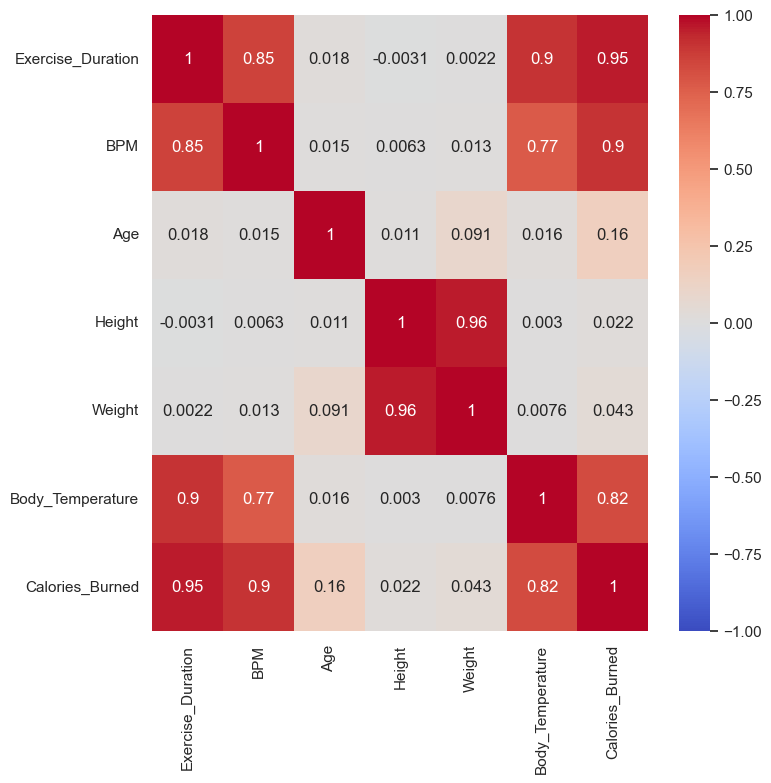

In [13]:
plt.figure(figsize=(8, 8))
sns.heatmap(df.corr(), vmin=-1.0, vmax=1.0, annot=True, cmap="coolwarm")

<Axes: xlabel='Age', ylabel='Count'>

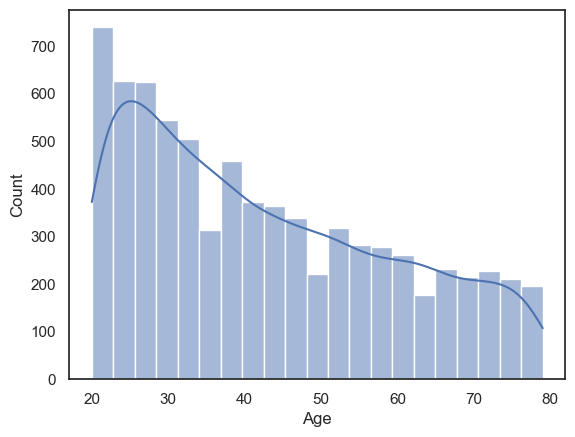

In [14]:
sns.histplot(data=df, x="Age", kde=True)

<Axes: xlabel='Body_Temperature', ylabel='Count'>

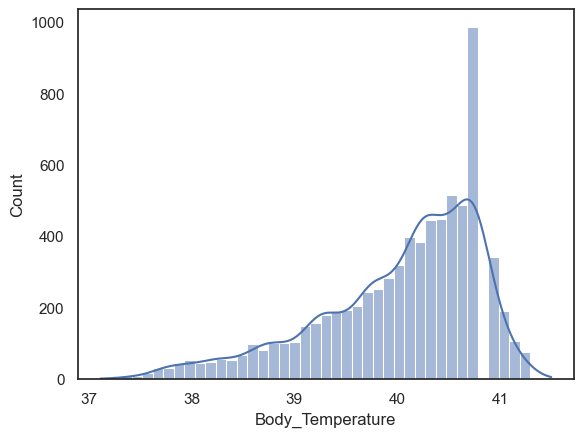

In [15]:
sns.histplot(data=df, x="Body_Temperature", kde=True)

<Axes: xlabel='Calories_Burned', ylabel='Count'>

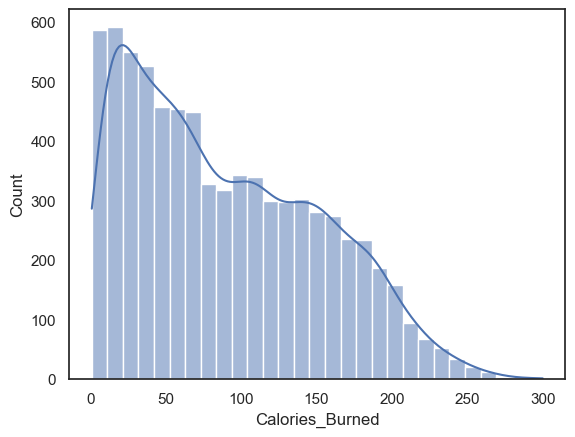

In [16]:
sns.histplot(data=df, x="Calories_Burned", kde=True)

<Axes: xlabel='Calories_Burned', ylabel='Count'>

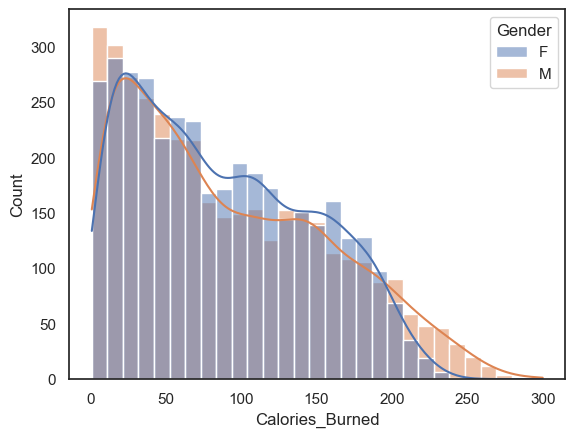

In [17]:
sns.histplot(data=df, x="Calories_Burned", hue="Gender", kde=True)

<Axes: xlabel='Exercise_Duration', ylabel='Calories_Burned'>

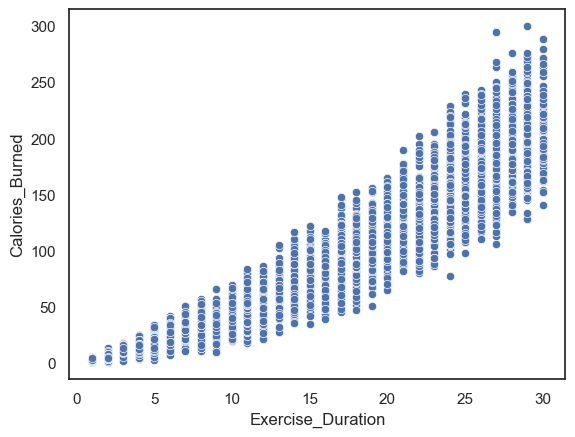

In [18]:
sns.scatterplot(data=df, x="Exercise_Duration", y="Calories_Burned")

<Axes: xlabel='Exercise_Duration', ylabel='Calories_Burned'>

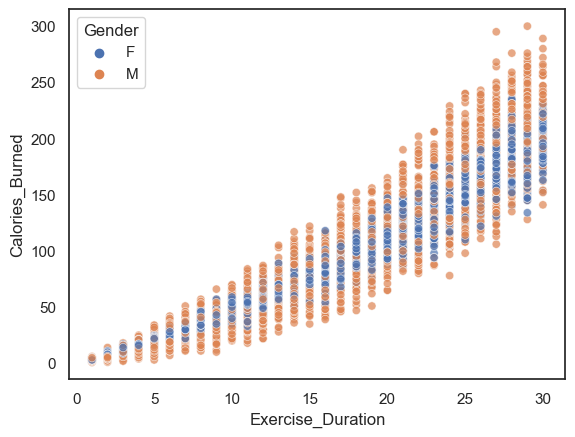

In [19]:
sns.scatterplot(data=df, x="Exercise_Duration", y="Calories_Burned", hue="Gender", alpha=0.7)

<Axes: xlabel='Weight_Status', ylabel='Calories_Burned'>

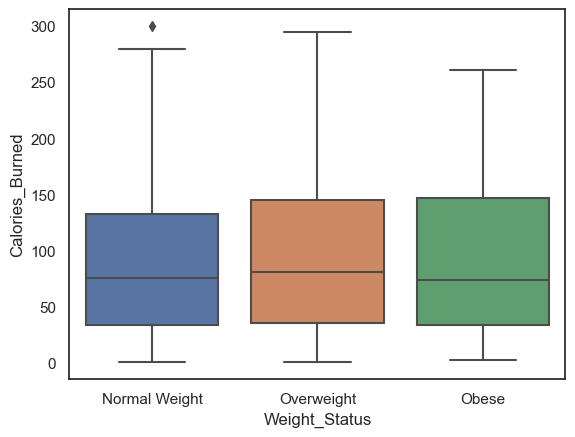

In [20]:
sns.boxplot(data=df, x="Weight_Status", y="Calories_Burned")

In [21]:
df["BMI"] = df["Weight"] / (df["Height"] / 100)**2
test["BMI"] = test["Weight"] / (test["Height"] / 100)**2

df = df.drop("Weight_Status", axis=1)
test = test.drop("Weight_Status", axis=1)

df["Gender"] = df["Gender"].map({"F": 0, "M": 1})
test["Gender"] = test["Gender"].map({"F": 0, "M": 1})

In [22]:
df["Calories_Burned"] = np.log1p(df["Calories_Burned"])

df["Age"] = np.log(df["Age"])
test["Age"] = np.log(test["Age"])

body_temp_mean = df["Body_Temperature"].mean()
body_temp_std = df["Body_Temperature"].std()
df["Body_Temperature"] = (((df["Body_Temperature"] - body_temp_mean) / body_temp_std) + 4)**3
test["Body_Temperature"] = (((test["Body_Temperature"] - body_temp_mean) / body_temp_std) + 4)**3

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torch.utils.data import DataLoader, Dataset, Subset 

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loops.fit_loop import FitLoop
from pytorch_lightning.loops.loop import Loop
from pytorch_lightning.trainer.states import TrainerFn

In [25]:
def seed_everything(seed: int) -> None:
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True  
    torch.backends.cudnn.benchmark = False  

In [26]:
numeric_columns = df.columns[df.dtypes == np.float]
target_column = "Calories_Burned"

In [27]:
# target
minmax_scaler = MinMaxScaler()  
df[target_column] = minmax_scaler.fit_transform(df[[target_column]])

# target외의 양적 변수
tmp_scaler = MinMaxScaler()
df[numeric_columns.drop(target_column)] = tmp_scaler.fit_transform(df[numeric_columns.drop(target_column)])
test[numeric_columns.drop(target_column)] = tmp_scaler.transform(test[numeric_columns.drop(target_column)])

In [28]:
class CustomDataset(Dataset):
    def __init__(
        self, 
        X: NDArray[np.float],
        y: Optional[NDArray[np.int]] = None
    ) -> None:
        self.X = X
        self.y = y

    def __getitem__(self, index: int) -> Union[Tuple[Tensor, Tensor, int], Tuple[Tensor, Tensor]]:
        X = torch.FloatTensor(self.X[index])
        if self.y is not None:
            y = torch.FloatTensor(self.y[index])  
            return X, y
        return X

    def __len__(self) -> int:
        return self.X.shape[0]

In [29]:
class BaseKFoldDataModule(pl.LightningDataModule, metaclass=ABCMeta):
    @abstractmethod
    def setup_folds(self, num_folds: int) -> None:
        ...

    @abstractmethod
    def setup_fold_index(self, fold_index: int) -> None:
        ...


class KFoldDataModule(BaseKFoldDataModule):
    def __init__(self, X: NDArray[np.float], y: NDArray[np.int], X_predict: NDArray[np.float], **kwargs: Any):
        super(KFoldDataModule, self).__init__()
        self.save_hyperparameters(logger=False)  
        self.X = X
        self.y = y
        self.X_predict = X_predict

    def setup(self, stage: str) -> None:
        self.dataset = CustomDataset(X, y)
        self.predict_dataset = CustomDataset(X_predict)

    def setup_folds(self, num_folds: int) -> None:
        self.num_folds = num_folds
        self.splits = [split for split in KFold(num_folds).split(range(len(self.dataset)))]

    def setup_fold_index(self, fold_index: int) -> None:
        train_indices, val_indices = self.splits[fold_index]
        self.train_dataset = Subset(self.dataset, train_indices)
        self.val_dataset = Subset(self.dataset, val_indices)

    def train_dataloader(self) -> None:
        return DataLoader(self.train_dataset, batch_size=self.hparams.bs, shuffle=True)

    def val_dataloader(self) -> None:
        return DataLoader(self.val_dataset, batch_size=self.hparams.bs, shuffle=False)

    def predict_dataloader(self) -> None:
        return DataLoader(self.predict_dataset, batch_size=self.hparams.bs, shuffle=False)

In [30]:
def get_block(in_features: int, out_features: int) -> nn.Sequential:
    return nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.BatchNorm1d(out_features),
            nn.GELU()
        )
        

def init_weights(model: nn.Module) -> None:
    classname = model.__class__.__name__
    if classname.find("Linear") != -1:
        y = model.in_features
        model.weight.data.normal_(0.0, np.sqrt(2 / y))
        model.bias.data.fill_(0)
    elif classname.find("BatchNorm") != -1:
        model.weight.data.normal_(1.0, 0.02)
        model.bias.data.fill_(0)


class Regressor(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.in_features_list = [8, 32, 64, 32]
        self.out_features_list = [32, 64, 32, 8]
        self.net = nn.Sequential(
            *[get_block(in_features, out_features) 
            for in_features, out_features in zip(self.in_features_list, self.out_features_list)]
        )
        self.fc = nn.Linear(self.out_features_list[-1], 1)  

    def forward(self, x: Tensor) -> Tensor:
        x = self.net(x)
        x = self.fc(x)
        return x 


class LightningRegressor(pl.LightningModule):
    def __init__(self, **kwargs: Any) -> None:
        super().__init__()
        self.save_hyperparameters(logger=False)
        self.model = Regressor().apply(init_weights)  

    def forward(self, x: Tensor) -> Tensor:
        return self.model(x)

    def on_train_start(self) -> None:
        self.log_dict({"fold": self.current_fold})

    def _shared_step(self, batch: Any, batch_idx: int) -> Dict[str, Tensor]:
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        return {"loss": loss, "y": y, "y_hat": y_hat}

    def training_step(self, batch: Any, batch_idx: int) -> Dict[str, Tensor]:
        return self._shared_step(batch, batch_idx)

    def training_epoch_end(self, outputs: Tensor) -> None:
        mean_loss = torch.stack([x["loss"] for x in outputs]).mean()
        if self.current_epoch % self.hparams.log_interval == 0:
            print(f"Epoch {self.current_epoch} | Train Loss: {mean_loss:.5f}", end=" " * 2)

    def validation_step(self, batch: Any, batch_idx: int) -> Any:
        return self._shared_step(batch, batch_idx)

    def validation_epoch_end(self, outputs: Tensor) -> None:
        y = torch.cat([x["y"] for x in outputs]).detach().cpu().numpy()
        y_hat = torch.cat([x["y_hat"] for x in outputs]).detach().cpu().numpy()
        val_rmse = mean_squared_error(np.expm1(minmax_scaler.inverse_transform(y)), np.expm1(minmax_scaler.inverse_transform(y_hat)), squared=False)
        mean_loss = torch.stack([x["loss"] for x in outputs]).mean()
        self.log_dict({"val_loss": mean_loss, "val_rmse": val_rmse}, logger=False)
        if self.current_epoch % self.hparams.log_interval == 0:
            print(f"Val Loss: {mean_loss:.5f}  Val RMSE: {val_rmse:.5f}")

    def predict_step(self, batch: Any, batch_idx: int, dataloader_idx: int = 0) -> NDArray[np.float]:
        x = batch
        pred = np.expm1(minmax_scaler.inverse_transform(self(x).detach().cpu().numpy()))
        return pred

    def configure_optimizers(self) -> Tuple[List[optim.Optimizer], List[optim.lr_scheduler._LRScheduler]]:
        optimizer = optim.AdamW(self.parameters(), lr=args.lr)
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.97)
        LightningModule.lr_scheduler_step
        return [optimizer], [scheduler]

In [31]:
class KFoldLoop(Loop):
    def __init__(self, num_folds: int, export_path: str) -> None:
        super().__init__()
        self.num_folds = num_folds
        self.current_fold = 0
        self.export_path = export_path

    @property
    def done(self) -> bool:
        return self.current_fold >= self.num_folds

    def connect(self, fit_loop: FitLoop) -> None:
        self.fit_loop = fit_loop

    def reset(self) -> None:
        """Nothing to reset in this loop."""

    def on_run_start(self, *args: Any, **kwargs: Any) -> None:
        """Used to call `setup_folds` from the `BaseKFoldDataModule` instance and store the original weights of the model."""
        assert isinstance(self.trainer.datamodule, BaseKFoldDataModule)
        self.trainer.ckpt_paths = []
        self.trainer._callbacks = deepcopy(self.trainer.callbacks)
        self.trainer.datamodule.setup_folds(self.num_folds)
        self.lightning_module_state_dict = deepcopy(self.trainer.lightning_module.state_dict())

    def on_advance_start(self, *args: Any, **kwargs: Any) -> None:
        """Used to call `setup_fold_index` from the `BaseKFoldDataModule` instance."""
        print("\n" * 2 + f"[{self.current_fold + 1} / {self.num_folds}] Fold Training......", end="\n" * 2)
        assert isinstance(self.trainer.datamodule, BaseKFoldDataModule)
        self.trainer.datamodule.setup_fold_index(self.current_fold)
        self.trainer.lightning_module.current_fold = self.current_fold

    def advance(self, *args: Any, **kwargs: Any) -> None:
        """Used to the run a fitting and testing on the current hold."""
        self._reset_fitting()  # requires to reset the tracking stage.
        self.fit_loop.run()

    def on_advance_end(self) -> None:
        """Used to save the weights of the current fold and reset the LightningModule and its optimizers."""
        self.trainer.ckpt_paths.append(self.trainer.checkpoint_callback.best_model_path)
        self.trainer.callbacks = deepcopy(self.trainer._callbacks)  # reset callbacks

        # restore the original weights + optimizers and schedulers.
        self.trainer.lightning_module.load_state_dict(self.lightning_module_state_dict)
        self.trainer.strategy.setup_optimizers(self.trainer)
        self.replace(fit_loop=FitLoop)
        self.current_fold += 1

    def on_save_checkpoint(self) -> Dict[str, int]:
        # 중간에 학습이 끊기고 처음부터 다시 시작하면 init 메서드에 의해 현재 폴드 순서는 0으로 초기화됨
        # 그 당시 학습할 때 폴드 순서를 알기 위해선 현재 폴드 순서도 알아야 하므로 저장
        return {"current_fold": self.current_fold}

    def on_load_checkpoint(self, state_dict: Dict) -> None:
        self.current_fold = state_dict["current_fold"]

    def _reset_fitting(self) -> None:
        self.trainer.reset_train_dataloader()
        self.trainer.reset_val_dataloader()
        self.current_epoch = 0
        self.global_step = 0
        self.trainer.state.fn = TrainerFn.FITTING
        self.trainer.training = True
        self.trainer.should_stop = False

    def _reset_predicting(self) -> None:
        self.trainer.reset_predict_dataloader()
        self.trainer.state.fn = TrainerFn.PREDICTING
        self.trainer.predicting = True

    @property
    def global_step(self) -> int:
        return self.fit_loop.global_step

    @global_step.setter
    def global_step(self, value: int) -> None:
        self.fit_loop.global_step = value

    @property
    def current_epoch(self) -> int:
        return self.fit_loop.current_epoch

    @current_epoch.setter
    def current_epoch(self, value: int) -> None:
        self.fit_loop.current_epoch = value

    def __getattr__(self, key: Any) -> Any:
        # requires to be overridden as attributes of the wrapped loop are being accessed.
        if key not in self.__dict__:
            return getattr(self.fit_loop, key)
        return self.__dict__[key]

    def __setstate__(self, state: Dict[str, Any]) -> None:
        self.__dict__.update(state)

In [32]:
class Trainer(pl.Trainer):
    def __init__(self, num_folds: int, export_path: str, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.num_folds = num_folds
        self.export_path = export_path
    # The provided lr scheduler `ExponentialLR` doesn't follow PyTorch's LRScheduler API.
    # You should override the `LightningModule.lr_scheduler_step` hook with your own logic if you are using a custom LR scheduler
    def cross_validate(self, model: pl.LightningModule, datamodule: pl.LightningDataModule) -> None:
        internal_fit_loop = self.fit_loop
        self.fit_loop = KFoldLoop(num_folds=self.num_folds, export_path=self.export_path)
        self.fit_loop.connect(internal_fit_loop)
        self.fit(model, datamodule)

    def predict(self, model: pl.LightningModule, datamodule: pl.LightningDataModule) -> NDArray[np.float]:
        preds = []
        for ckpt_path in tqdm(self.ckpt_paths):
            pred = super().predict(model, datamodule=datamodule, ckpt_path=ckpt_path)
            pred = np.concatenate(pred)
            preds.append(pred)
        preds = np.array(preds).mean(0)
        return preds

In [33]:
y = df.pop(target_column).values.reshape(-1, 1)
X = df.to_numpy()
X_predict = test.to_numpy()

In [34]:
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
seed_everything(args.seed)
model = LightningRegressor(**args)
datamodule = KFoldDataModule(X, y, X_predict, **args)

es = EarlyStopping(monitor="val_rmse", 
                   patience=50,
                   verbose=False,
                   mode="min")

mc = ModelCheckpoint(dirpath=args.weights_path,
                     filename="{fold}-{epoch}-{val_rmse:.2f}",
                     monitor="val_rmse",
                     mode="min",
                     save_weights_only=True)

trainer = Trainer(
    num_folds=args.num_folds,
    export_path=args.weights_path,
    max_epochs=args.max_epochs,
    num_sanity_val_steps=0,
    gradient_clip_val=args.gradient_clip_val,
    enable_progress_bar=False, 
    enable_model_summary=False,
    devices=1,
    accelerator="cpu",
    callbacks=[es, mc]
)

trainer.cross_validate(model, datamodule)

MisconfigurationException: The provided lr scheduler `ExponentialLR` doesn't follow PyTorch's LRScheduler API. You should override the `LightningModule.lr_scheduler_step` hook with your own logic if you are using a custom LR scheduler.